In [1]:
import os
import pandas as pd
import sys
import datetime
import math
import time
import folium
from vega import VegaLite

## Bus Bunching Detection

1. Bus Bunching Detection in python: read BUSTE output (concatenates all files per day) and compare each gps point (shape point) with all of the same route-shapeID-hourMinute. If they are less then 100 m away and 5 minutes away, they are considered BB.
2. Read all file concatenated and group by key in R to facilitate visualizations.
3. Do visualization in Vega-Lite and put here.

In [ ]:
def readFiles(dataPath):
    dataFrames = []
    
    # Create one file by day of analysis
    for dirName in os.listdir(dataPath):
        allBusteData = []
        for fileName in os.listdir(dataPath + dirName):
            filePath = dataPath + dirName +  "/" + fileName
            if ("part-" in fileName):
                allBusteData.append(pd.read_csv(filePath))

         # Concatenate all data of one day into one DataFrame
        dataByDay = pd.concat(allBusteData, ignore_index = True)
        print("Day " + dataByDay['gps_datetime'][0].split(" ")[0])
        dataFrames.append(dataByDay)

    #dataFrames.append(pd.read_csv(dataPath + "test")) # TODO just for test

    return dataFrames

In [ ]:
def processingData(dataFrames):

    dataFramesFiltered = []
    
    for dataByDay in dataFrames:
        
        # Remove unusable columns
        dataByDay = dataByDay.drop(['shapeSequence', 'distanceTraveledShape', 'gpsPointId', 'distanceToShapePoint', 'stopPointId',
                            'birthdate', 'boarding_id', 'boarding_datetime', 'lineName', 'cardNum', 'gender'], axis = 1)

        print("After filter columns: ", dataByDay.shape)

        # Removing data without gps point
        before = dataByDay.shape[0]
        
        dataByDay = dataByDay[(dataByDay.gpsLat != "-") & (dataByDay.problem != "TRIP_PROBLEM")]
        dataByDay = dataByDay.drop(['problem'], axis = 1)
        
        print("After remove rows without GPS: ", dataByDay.shape)
        after = dataByDay.shape[0]
        deleted_rows = before - after
        print("Deleted rows", deleted_rows)

        # Fixing index by number of rows
        dataByDay = dataByDay.reset_index(drop = True)
        
        # Creating new column id to index rows
        dataByDay.insert(0, "id", dataByDay.index)

        # Creating new column time to group by timestamp and reduce comparisons
        dataByDay.insert(1, "time", dataByDay.gps_datetime.str[11:15])
        
        # Convert timestamp to date
        dataByDay['date'] =  dataByDay['gps_datetime'].str.split(" ", n = 1).str[0]
        dataByDay['gps_datetime'] =  pd.to_datetime(dataByDay['gps_datetime'])
        
        print("Processed data: ")
        print(dataByDay.head())
        
        dataFramesFiltered.append(dataByDay)
        
    return dataFramesFiltered

In [ ]:
# Output dataframe to add Bus Bunching occurrence
def createOutputDataframe(dataByDay):
    outputBusBunching = dataByDay
    outputBusBunching['busBunching'] = "" # create new column

    return outputBusBunching

In [ ]:
def distanceBetween(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_m : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d * 1000 #meters

In [ ]:
def isBusBunching(distance, threshold):
    """
    Detecting Bus Bunching.

    Parameters
    ----------
    distance : distance between two gps points
        float

    Returns
    -------
    is_bus_bunching : boolean

    Examples
    --------
    >>> distance = 98.08
    true
    """
    return distance < threshold

In [ ]:
def generateOutputBusBunchingDetection(dataByDay, dataByDayOutput, route_buses_dic, distanceThreshold, 
                                       intervalTimeThreshold, outputPath):

    outputBusBunching = dataByDayOutput
    
    for row in dataByDay.itertuples():
        """
        Index=0, id=0, time='05:4', route=463, tripNum=1, shapeId=2846, shapeLat=-25.478024708433903, 
        shapeLon=-49.203032595858183, busCode='DC090', gpsLat='-25.477931', gpsLon='-49.203043', 
        gps_datetime=Timestamp('2017-04-30 05:48:27'), date='2017-04-30', busBunching=''
        """
        
        indexFirstBus = row[1]
        timeFirstBus = row[2]
        routeFirstBus = row[3]
        shapeIdFirstBus = row[5]
        latitudeFirstBus = row[6]
        longitudeFirstBus = row[7]
        codeFirstBus = row[8]
        timestampFirstBus = row[11]

        closestTime = ""
        previousBus = ""

        # Compare buses from the same route and shape id (avoiding buses in opposite trips, e.g.)
        # and in time range (avoiding buses in different hours, e.g.)
        buses_same_route = route_buses_dic[routeFirstBus, timeFirstBus, shapeIdFirstBus]

        for rowOtherBus in buses_same_route:
            """
            [0, '05:4', 463, 1, 2846, -25.478024708433903, -49.20303259585818, 'DC090', '-25.477931', '-49.203043', 
            Timestamp('2017-04-30 05:48:27'), '2017-04-30']
            """
            
            indexOtherBus = rowOtherBus[0]
            routeOtherBus = rowOtherBus[2]
            codeOtherBus = rowOtherBus[7]
            timestampOtherBus = rowOtherBus[10]
            latitudeOtherBus = rowOtherBus[5]
            longitudeOtherBus = rowOtherBus[6]


            if (codeOtherBus != codeFirstBus): # avoiding to compare with the same bus
                difTime = abs(timestampOtherBus - timestampFirstBus)

                if (previousBus == codeOtherBus):

                    #find the nearest timestamps

                    if (difTime < closestTime):
                        closestTime = difTime
                        closestBusCode = codeOtherBus
                        closestLat = latitudeOtherBus
                        closestLon = longitudeOtherBus
                        closestID = indexOtherBus

                else:
                    #first, analyse the last bus

                    if (closestTime != "" and (closestTime < datetime.timedelta(seconds = intervalTimeThreshold))):
                        distance = distanceBetween((float(latitudeFirstBus), float(longitudeFirstBus)), 
                                                   (float(closestLat), float(closestLon)))

                        if (isBusBunching(distance, distanceThreshold)):
                            bbFirstBus = outputBusBunching.iloc[indexFirstBus]["busBunching"]
                            if (str(closestID) not in bbFirstBus):

                                if (str(indexFirstBus) not in bbFirstBus):
                                    outputBusBunching.loc[indexFirstBus,'busBunching'] = str(indexFirstBus) + "-" + str(closestID) + "-"
                                else:
                                    outputBusBunching.loc[indexFirstBus,'busBunching'] = bbFirstBus + str(closestID) + "-"

                            bbClosestBus = outputBusBunching.iloc[closestID]["busBunching"]
                            if (str(indexFirstBus) not in bbClosestBus):

                                if (str(closestID) not in bbClosestBus):
                                    outputBusBunching.loc[closestID,'busBunching'] = str(indexFirstBus) + "-" + str(closestID) + "-"
                                else:
                                    outputBusBunching.loc[closestID,'busBunching'] = bbClosestBus + str(indexFirstBus) + "-"

                    # -----------------------------------------
                    # New bus to compare: reseting variables
                    previousBus = codeOtherBus
                    closestTime = difTime
                    closestBusCode = codeOtherBus
                    closestLat = latitudeOtherBus
                    closestLon = longitudeOtherBus
                    closestID = indexOtherBus
    
    print("Output Bus Bunching " + outputBusBunching['date'][0])
    print(outputBusBunching.loc[outputBusBunching['busBunching'] != ""].head())
    saveToCSV(outputBusBunching, outputBusBunching["date"][0], outputPath)


In [ ]:
# Saving csv file
def saveToCSV(outputByDay, date, outputPath):
    # to print bus bunching
    # outputBusBunching.loc[outputBusBunching['busBunching'] != ""]
    
    outputByDay.to_csv(outputPath + "outputBusBunching-" + date + ".csv", index_label = "index", encoding = 'utf-8')

In [ ]:
def executeDetection(dataFramesFiltered, distanceThreshold, intervalTimeThreshold, outputPath):
    
    for dataByDay in dataFramesFiltered:
        outputByDay = createOutputDataframe(dataByDay)
        
        # Mapping route - buses
        route_buses_dic = dataByDay.groupby(['route', 'time', 'shapeId']).apply(lambda f: f[["id", "time", "route", "tripNum", 
                                                                                             "shapeId", "shapeLat", "shapeLon", 
                                                                                             "busCode", "gpsLat", "gpsLon", 
                                                                                             "gps_datetime", 
                                                                                             "date"]].values.tolist()).to_dict()
        generateOutputBusBunchingDetection(dataByDay, outputByDay, route_buses_dic, distanceThreshold, 
                                           intervalTimeThreshold, outputPath)    

In [ ]:
def main():
    start_time = time.time()
    
    DISTANCE_THRESHOLD = 100 # maximal difference in meters to consider BB
    INTERVAL_TIME_THRESHOLD = 5 # maximal difference in minutes to consider BB

    inputPath = os.getcwd() + "/data/buste/"
    outputPath = os.getcwd() + "/data/outputBusBunching/"
    
    dataFrames = readFiles(inputPath)
    dataFramesFiltered = processingData(dataFrames)
    
    executeDetection(dataFramesFiltered, DISTANCE_THRESHOLD, INTERVAL_TIME_THRESHOLD, outputPath)
    
    executionTime = int(time.time() - start_time) / 60
    print("--- %s minutes ---" % executionTime)

In [ ]:
if __name__ == '__main__':
    main()

In [ ]:
def concatOutputFiles(dataPath):
    
    # Create one file by day of analysis
    allOutputData = []
    for fileName in os.listdir(dataPath):
        filePath = dataPath +  "/" + fileName
        if ("outputBusBunching-" in fileName):
            allOutputData.append(pd.read_csv(filePath))

     # Concatenate all data of one day into one DataFrame
    allOutputData = pd.concat(allOutputData, ignore_index = True)

    return allOutputData

outputPath = os.getcwd() + "/data/outputBusBunching/"
outputFiles = concatOutputFiles(outputPath)
saveToCSV(outputFiles, "allData", outputPath)


## Validation

In [ ]:
def plotMarkersOnMap(outputBusBunching):
    
    from IPython.display import HTML, display
    # Validating bus bunching at map

    # filter rows with bus bunching
    busBunching = outputBusBunching.loc[outputBusBunching["busBunching"].notnull()]

    # create dic route - color
    colors = {"orange", "blue", "brown", "pink", "black", "red", "green", "purple"} 
    busBunchingRoutes = busBunching.route.unique()
    print("Routes with BB: ", busBunchingRoutes)
    routeColorDict = dict(zip(busBunchingRoutes, colors))

    # Make an empty map
    m = folium.Map(tiles = "OpenStreetMap", zoom_start = 13, location = [-25.428777,-49.249120])

    # I can add marker one by one on the map
    for i in range(0, len(busBunching)):
        route = busBunching.iloc[i]['route']
        id = busBunching.iloc[i]['id']
        popup_data = "route: " + str(route) + " id: " + str(id) + " Bus Code: " + str(busBunching.iloc[i]['busCode']) + " Timestamp: " + str(busBunching.iloc[i]['gps_datetime']) + " BB: " + str(busBunching.iloc[i]['busBunching'])

        folium.CircleMarker([busBunching.iloc[i]['gpsLat'], busBunching.iloc[i]['gpsLon']], popup = popup_data, 
                            color = routeColorDict[route], radius = 10, fill_opacity = 0.9).add_to(m)

     # Save it as html
    m.save('bus_bunching_visualization.html')

    m

def validationOnMap():
    dayOfAnalysis = "2017-05-01.csv"
    filePath = os.getcwd() + "/data/outputBusBunching/outputBusBunching-" + dayOfAnalysis
    outputBusBunching = pd.read_csv(filePath)
    
    #print(outputBusBunching[outputBusBunching["busBunching"] != ""])
    
    plotMarkersOnMap(outputBusBunching)

In [ ]:
if __name__ == '__main__':
    validationOnMap()

## Analysis - Month: May 2017


### Por rota

Total de rotas: 260

**Com aglomerados: 90 rotas (35%)**

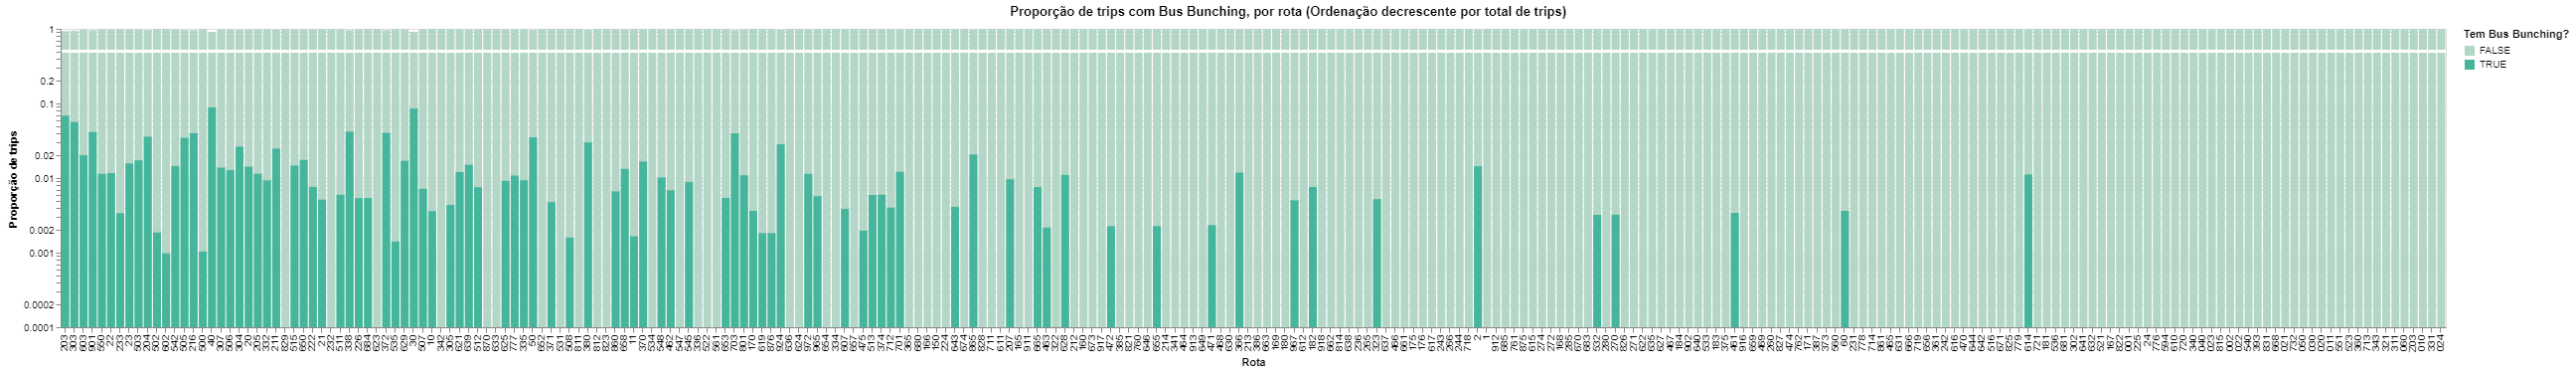

In [14]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "width": 2400,
  "height": 300,
  "title": {
    "text": "Proporção de trips com Bus Bunching, por rota (Ordenação decrescente por total de trips)"
  },
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/ffc96bafd0ae0bfa42a965d2bbce73ce/raw/49f528ba08e89381d0bea7e7387c8463973b3c08/bb_per_route_curitiba-may-2017.csv"
  },
  "transform": [
    {
      "calculate": "0.5",
      "as": "ref"
    }
  ],
  "layer": [
    {
      "mark": {
        "type": "bar",
        "size": 8
      },
      "encoding": {
        "x": {
          "field": "route",
          "type": "nominal",
          "axis": {
            "title": "Rota"
          },
          "sort": {
            "op": "sum",
            "field": "trips",
            "order": "descending"
          }
        },
        "color": {
          "field": "hasBusBunching",
          "type": "nominal",
          "legend": {
            "title": "Tem Bus Bunching?"
          },
          "scale": {
            "range": [
              "#B3D6C6",
              "#45B69C"
            ]
          }
        },
        "y": {
          "field": "percTrips",
          "type": "quantitative",
            "scale": {"type": "log"},
          "stack": None,
          "axis": {
            "title": "Proporção de trips"
          }
        },
        "tooltip": [
          {
            "field": "route",
            "type": "nominal",
            "title": "Route"
          },
          {
            "field": "hasBusBunching",
            "type": "nominal",
            "title": "Has BB?"
          },
          {
            "field": "trips",
            "type": "quantitative",
            "title": "Total trips"
          },
          {
            "field": "percTrips",
            "type": "quantitative",
            "title": "Trips %"
          }
        ]
      }
    },
    {
      "mark": "rule",
      "encoding": {
        "y": {
          "field": "ref",
          "type": "quantitative"
        },
        "color": {
          "value": "white"
        },
        "size": {
          "value": 2
        }
      }
    }
  ]
})

### Por ônibus

Total de ônibus: 1523

**Com aglomerados: 735 ônibus (48%)**

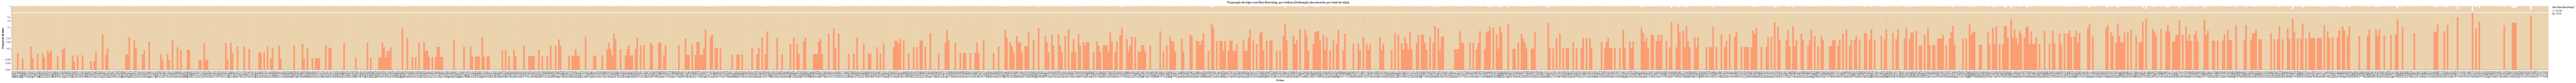

In [15]:
VegaLite(
{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "width": 12000,
  "height": 300,
  "title": {
    "text": "Proporção de trips com Bus Bunching, por ônibus (Ordenação decrescente por total de trips)"
  },
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/028d44a782225b08b664a7cd486c6a2a/raw/2a8b885cb7be922de574e8980ca78a356ca65eb3/bb_per_bus_curitiba-may-2017.csv"
  },
  "transform": [{"calculate": "0.5", "as": "ref"}],
  "layer": [
    {
      "mark": {"type": "bar", "size": 8},
      "encoding": {
        "x": {
          "field": "busCode",
          "type": "nominal",
          "axis": {"title": "Ônibus"},
          "sort": {"op": "sum", "field": "trips", "order": "descending"}
        },
        "color": {
          "field": "hasBusBunching",
          "type": "nominal",
          "legend": {"title": "Tem Bus Bunching?"},
          "scale": {"range": ["#EAD2AC", "#FF9B71"]}
        },
        "y": {
          "field": "percTrips",
          "type": "quantitative",
            "scale": {"type": "log"},
          "stack": None,
          "axis": {"title": "Proporção de trips"}
        },
        "tooltip": [
          {"field": "busCode", "type": "nominal", "title": "Bus Code"},
          {"field": "hasBusBunching", "type": "nominal", "title": "Has BB?"},
          {"field": "trips", "type": "quantitative", "title": "Total trips"},
          {"field": "percTrips", "type": "quantitative", "title": "Trips %"}
        ]
      }
    },
    {
      "mark": "rule",
      "encoding": {
        "y": {"field": "ref", "type": "quantitative"},
        "color": {"value": "white"},
        "size": {"value": 2}
      }
    }
  ]
})

### Por hora do dia e rota

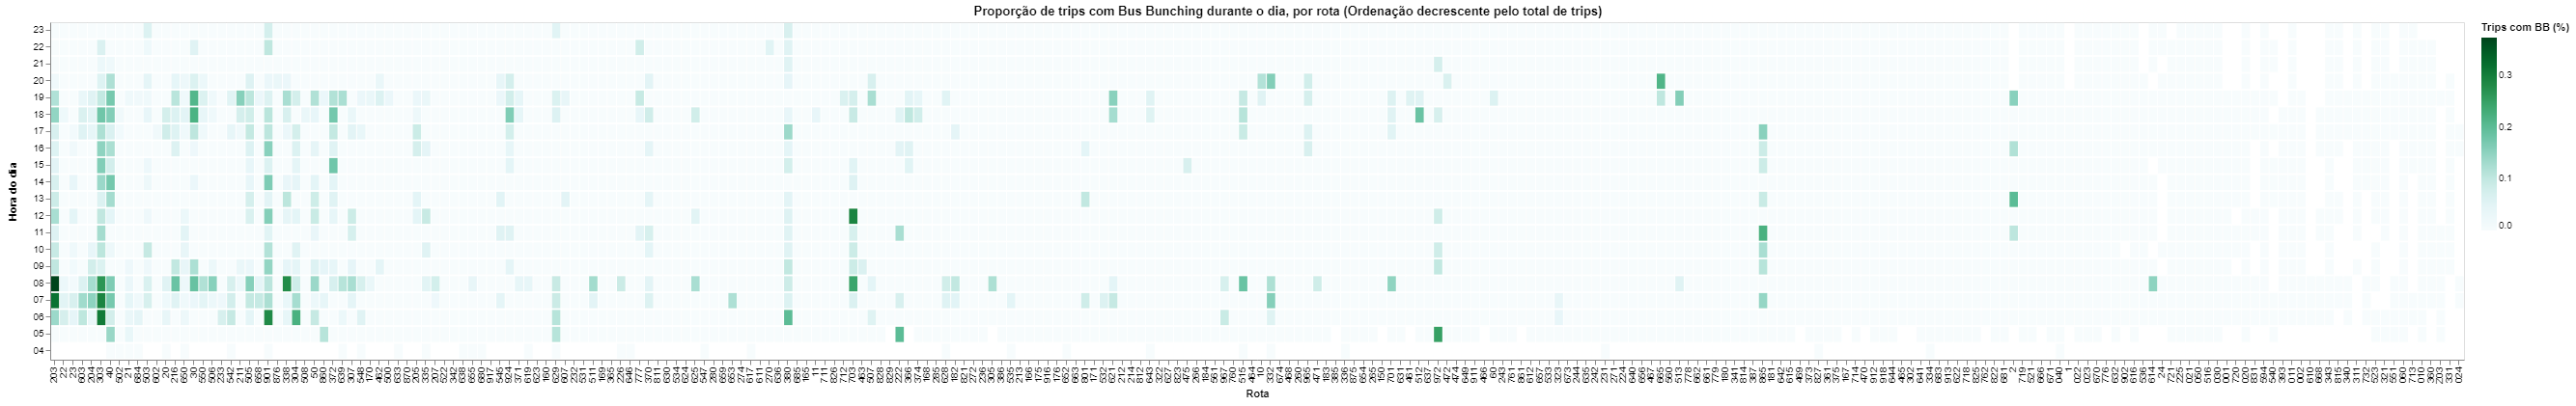

In [7]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 2500,
  "height": 350,
  "title": "Proporção de trips com Bus Bunching durante o dia, por rota (Ordenação decrescente pelo total de trips)",
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/963f8d62ad5bbf1711ca8299bd84f0ed/raw/41c1cb22a20e31e060269ab77f62c6cb8dbbd3c2/bb_per_route_hour_curitiba-may-2017.csv"
  },
  "mark": {"type": "rect"},
  "encoding": {
    "y": {
      "field": "time",
      "type": "ordinal",
      "title": "Hora do dia",
      "sort": "descending"
    },
    "tooltip": [
      {"field": "time", "type": "ordinal", "title": "Hora"},
      {
        "field": "trips",
        "type": "quantitative",
        "title": "Total trips with BB"
      },
      {
        "field": "percTripsWithBB",
        "type": "quantitative",
        "title": "Trips with BB %"
      }
    ],
    "x": {
      "field": "route",
      "type": "nominal",
      "title": "Rota",
      "sort": {"op": "sum", "field": "trips", "order": "descending"}
    },
    "color": {
      "field": "percTripsWithBB",
      "type": "quantitative",
      "legend": {"title": "Trips com BB (%)"},
      "scale": {"scheme": "bluegreen"}
    }
  }
})

### Por hora do dia

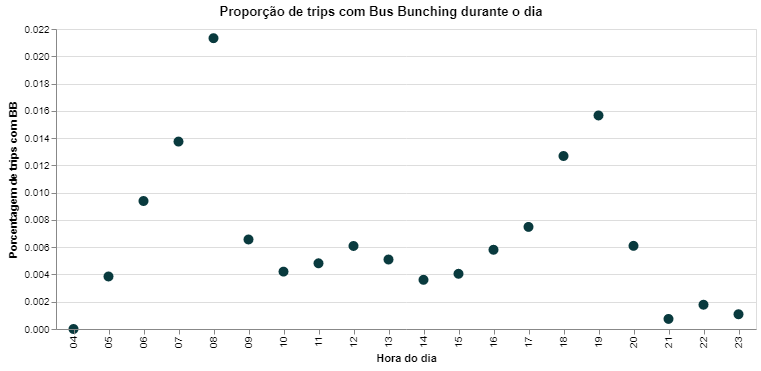

In [6]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 700,
  "height": 300,
  "title": "Proporção de trips com Bus Bunching durante o dia",
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/963f8d62ad5bbf1711ca8299bd84f0ed/raw/41c1cb22a20e31e060269ab77f62c6cb8dbbd3c2/bb_per_route_hour_curitiba-may-2017.csv"
  },
  "mark": {"type": "point", "filled": True, "size": 100},
  "encoding": {
    "x": {"field": "time", "type": "ordinal", "title": "Hora do dia"},
    "y": {
      "field": "percTripsWithBB",
      "aggregate": "mean",
      "type": "quantitative",
      "title": "Porcentagem de trips com BB",
      "sort": "ascending"
    },
    "tooltip": [
      {"field": "time", "type": "ordinal", "title": "Hora"},
      {
        "field": "percTripsWithBB",
        "type": "quantitative",
        "aggregate": "mean",
        "title": "Trips with BB %"
      }
    ],
    "color": {"value": "#093A3E"}
  }
})